# LearningPySpark_Ch04 
# Prepare Data for Modeling 
 - 모든 데이터는 우리가 생각하는 것 같이 깨끗하지 않다. 
 - Missing Data, Outlier, wrong number 등 다양한 이유로 데이터가 손실되거나 변형 되어 있다. 
 - Data Modeling을 하기 전에 데이터 전처리 과정이 필요하고 깨끗하게 유지 되어야한다. 
 - As a data scientist, Spend 80-90% of time massaging Data and getting familiar with all the features 

### In this chapter, you will learn how to do the following:
 - Recognize and handle duplicates, missing observations, and outliers
 - Calculate descriptive statistics and correlations
 - Visualize your data with matplotlib and Bokeh

## Checking for duplicates, missing bservations, and outliers

## 1. Duplicates
 - Duplicates are observations that appear as distinct rows in your dataset, but which, upon closer inspection, look the same.

#### Consider the follwing example:

In [1]:
df = spark.createDataFrame([
        (1, 144.5, 5.9, 33, 'M'),
        (2, 167.2, 5.4, 45, 'M'),
        (3, 124.1, 5.2, 23, 'F'),
        (4, 144.5, 5.9, 33, 'M'),
        (5, 133.2, 5.7, 54, 'F'),
        (3, 124.1, 5.2, 23, 'F'),
        (5, 129.2, 5.3, 42, 'M'),
    ], ['id', 'weight', 'height', 'age', 'gender'])

 - IDs 3 : 전체 데이터가 동일 
 - IDs (1,4) — ID만 다르고 나머지 데이터는 동일하다. 즉, 같은 사람이다.  
 - IDs 5 : ID만 동일하고 나머지 데이터는 다르다. 즉, 다른 사람이라고 볼 수 있다.
 
 
 - I compare the counts of the full dataset with the one that I get after running a .distinct() method

In [2]:
print('Count of rows: {0}'.format(df.count()))

Count of rows: 7


In [3]:
print('Count of distinct rows: {0}'.format(df.distinct().count()))

Count of distinct rows: 6


We can drop these rows by using the $.dropDuplicates(...)$ method
 - drop duplicates with all column's value

In [4]:
df = df.dropDuplicates()
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  4| 144.5|   5.9| 33|     M|
|  1| 144.5|   5.9| 33|     M|
|  5| 129.2|   5.3| 42|     M|
|  5| 133.2|   5.7| 54|     F|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
+---+------+------+---+------+



 - ID 가 3인 데이터는 삭제 되었다. 
 - ID를 통해서 중복된 데이터를 체크 쉽게 할 수 있다. 하지만 다른 컬럼까지 체크해서 하기에는 어려움이 있다. 

In [5]:
print('Count of ids : {0}'.format(df.count()))

Count of ids : 6


In [6]:
[c for c in df.columns if c != 'id']

['weight', 'height', 'age', 'gender']

 - ID를 제외한 나머지 컬럼의 데이터 비교 

In [7]:
print('Count of distinct ids : {0}'.format(df.select([c for c in df.columns if c != 'id']).distinct().count()))

Count of distinct ids : 5


 - see one more row that is a duplicate
 - 1,4 ID 를 가진 데이터 중 삭제 ID : 1 데이터 삭제 


 - We can still use the .dropDuplicates(...), but will add the subset parameter that specifies only the columns other than the id column

In [8]:
df = df.dropDuplicates(subset=[c for c in df.columns if c != 'id'])

In [11]:
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



In [12]:
import pyspark.sql.functions as fn

In [13]:
df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('count')
).show()

+-----+-----+
|count|count|
+-----+-----+
|    5|    4|
+-----+-----+



 - we will give each row a unique ID
 - The $.monotonicallymonotonically_increasing_id()$ method gives each record a unique and increasing ID

In [14]:
df.withColumn('new_id', fn.monotonically_increasing_id()).show()

+---+------+------+---+------+-------------+
| id|weight|height|age|gender|       new_id|
+---+------+------+---+------+-------------+
|  5| 133.2|   5.7| 54|     F|  25769803776|
|  4| 144.5|   5.9| 33|     M| 171798691840|
|  2| 167.2|   5.4| 45|     M| 592705486848|
|  3| 124.1|   5.2| 23|     F|1236950581248|
|  5| 129.2|   5.3| 42|     M|1365799600128|
+---+------+------+---+------+-------------+



## 2. Missing observations
 - Null, NA 에 대한 데이터를 다루게 될 것이다. 
 - 1. Missing Data가 있는 전체 데이터 삭제. 
 - 2. Impute some value in place of those Nones.

In [15]:
df_miss = spark.createDataFrame([
    (1, 143.5, 5.6, 28, 'M', 100000),
    (2, 167.2, 5.4, 45, 'M', None),
    (3, None , 5.2, None, None, None),
    (4, 144.5, 5.9, 33, 'M', None),
    (5, 133.2, 5.7, 54, 'F', None),
    (6, 124.1, 5.2, None, 'F', None),
    (7, 129.2, 5.3, 42, 'M', 76000),
], ['id', 'weight', 'height', 'age', 'gender', 'income'])

In [16]:
df_miss.collect()

[Row(id=1, weight=143.5, height=5.6, age=28, gender='M', income=100000),
 Row(id=2, weight=167.2, height=5.4, age=45, gender='M', income=None),
 Row(id=3, weight=None, height=5.2, age=None, gender=None, income=None),
 Row(id=4, weight=144.5, height=5.9, age=33, gender='M', income=None),
 Row(id=5, weight=133.2, height=5.7, age=54, gender='F', income=None),
 Row(id=6, weight=124.1, height=5.2, age=None, gender='F', income=None),
 Row(id=7, weight=129.2, height=5.3, age=42, gender='M', income=76000)]

In [29]:
df_miss.show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  1| 143.5|   5.6|  28|     M|100000|
|  2| 167.2|   5.4|  45|     M|  null|
|  3|  null|   5.2|null|  null|  null|
|  4| 144.5|   5.9|  33|     M|  null|
|  5| 133.2|   5.7|  54|     F|  null|
|  6| 124.1|   5.2|null|     F|  null|
|  7| 129.2|   5.3|  42|     M| 76000|
+---+------+------+----+------+------+



### Rows
 - ID : 3, Height만 유용한 데이터이다.
 - ID : 6, Age, Income 에 대해서 MIssing Data이다. 

### Columns
 - income : 대부분이 MIssing Value이다. 
 - weight, gender : 각 Row에 대해서 1개의 Row에서만 Missing Value가 있다. 
 - age : two missing values

### Each row counts Missing Data

In [17]:
df_miss.rdd.map(
    lambda row: (row['id'], sum([c==None for c in row]))
).collect()

[(1, 0), (2, 1), (3, 4), (4, 1), (5, 1), (6, 2), (7, 0)]

In [18]:
df_miss.where('id==3').show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  3|  null|   5.2|null|  null|  null|
+---+------+------+----+------+------+



### Let's now check what percentage of missing observations are there in each columns
 - 각 컬럼을 전체 표현하려면 *[]로 가변 list형태로 만들어줘야한다. 

In [28]:
df_miss.agg(*[fn.count('*').alias(c+"_total") for c in df_miss.columns]).show()

+--------+------------+------------+---------+------------+------------+
|id_total|weight_total|height_total|age_total|gender_total|income_total|
+--------+------------+------------+---------+------------+------------+
|       7|           7|           7|        7|           7|           7|
+--------+------------+------------+---------+------------+------------+



In [30]:
df_miss.agg(*[fn.count(c).alias(c+"_some") for c in df_miss.columns]).show() # not None in data value

+-------+-----------+-----------+--------+-----------+-----------+
|id_some|weight_some|height_some|age_some|gender_some|income_some|
+-------+-----------+-----------+--------+-----------+-----------+
|      7|          6|          7|       5|          6|          2|
+-------+-----------+-----------+--------+-----------+-----------+



In [19]:
df_miss.agg(
    *[(1-(fn.count(c) / fn.count('*'))).alias(c +'_missing') for c in df_miss.columns
]).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



### Drop column don't need

In [31]:
df_miss_no_income = df_miss.select([ c for c in df_miss.columns if c != 'income'])
df_miss_no_income.show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  3|  null|   5.2|null|  null|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



### Drop row (have many missing data) 
 - ID : 3

In [32]:
df_miss_no_income.dropna(thresh=3).show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



### Impute the ovservations, fillna method
 - This method accepts a single integer (long is also accepted),float, or string
 - all missing values in the whole dataset will then be filled in with that value
 - You can also pass a dictionary of a form $\{'<colName>': <value_to_impute>\}$
 - We omit the $gender$ column as one $cannot \ calculate$ a mean of a categorical variable, obviously.

In [36]:
df_miss_no_income.agg(
*[fn.mean(c).alias(c) for c in df_miss_no_income.columns if c!='gender']).show()

+---+------------------+-----------------+----+
| id|            weight|           height| age|
+---+------------------+-----------------+----+
|4.0|140.28333333333333|5.471428571428572|40.4|
+---+------------------+-----------------+----+



In [37]:
df_miss_no_income.agg(
*[fn.mean(c).alias(c) for c in df_miss_no_income.columns if c!='gender']).toPandas()

,id,weight,height,age
0,4.0,140.283333,5.471429,40.4


In [39]:
df_miss_no_income.agg(
*[fn.mean(c).alias(c) for c in df_miss_no_income.columns if c!='gender']).toPandas().to_dict('records')

[{'age': 40.399999999999999,
  'height': 5.4714285714285724,
  'id': 4.0,
  'weight': 140.28333333333333}]

In [40]:
df_miss_no_income.agg(
*[fn.mean(c).alias(c) for c in df_miss_no_income.columns if c!='gender']).toPandas().to_dict() # 이렇게 하면 한방에 끝날거같다.

{'age': {0: 40.399999999999999},
 'height': {0: 5.4714285714285724},
 'id': {0: 4.0},
 'weight': {0: 140.28333333333333}}

In [34]:
means = df_miss_no_income.agg(
*[fn.mean(c).alias(c) for c in df_miss_no_income.columns if c!='gender']).toPandas().to_dict('records')[0]

In [35]:
means

{'age': 40.399999999999999,
 'height': 5.4714285714285724,
 'id': 4.0,
 'weight': 140.28333333333333}

In [41]:
means['gender'] = 'missing'

In [43]:
means

{'age': 40.399999999999999,
 'gender': 'missing',
 'height': 5.4714285714285724,
 'id': 4.0,
 'weight': 140.28333333333333}

In [44]:
df_miss_no_income.fillna(means).show() # fillna(dictionary)

+---+-------------+------+---+-------+
| id|       weight|height|age| gender|
+---+-------------+------+---+-------+
|  1|        143.5|   5.6| 28|      M|
|  2|        167.2|   5.4| 45|      M|
|  3|140.283333333|   5.2| 40|missing|
|  4|        144.5|   5.9| 33|      M|
|  5|        133.2|   5.7| 54|      F|
|  6|        124.1|   5.2| 40|      F|
|  7|        129.2|   5.3| 42|      M|
+---+-------------+------+---+-------+



## 3. Outliers
 - 분포에서 크게 벗어난 데이터를 Outlier라 한다. 
 - Q1-1.5IQR 및 Q3 + 1.5IQR 범위 (여기서 IQR은 사 분위 범위 임)
  - IQR 상한 및 하한 사 분위수의 차이, 즉 75 백분위 수 (Q3)와 25 백분위 수 (Q1)입니다.

In [87]:
df_outliers = spark.createDataFrame([
        (1, 143.5, 5.3, 28),
        (2, 154.2, 5.5, 45),
        (3, 342.3, 5.1, 99),
        (4, 144.5, 5.5, 33),
        (5, 133.2, 5.4, 54),
        (6, 124.1, 5.1, 21),
        (7, 129.2, 5.3, 42),
    ], ['id', 'weight', 'height', 'age'])

In [88]:
df_outliers.show()

+---+------+------+---+
| id|weight|height|age|
+---+------+------+---+
|  1| 143.5|   5.3| 28|
|  2| 154.2|   5.5| 45|
|  3| 342.3|   5.1| 99|
|  4| 144.5|   5.5| 33|
|  5| 133.2|   5.4| 54|
|  6| 124.1|   5.1| 21|
|  7| 129.2|   5.3| 42|
+---+------+------+---+



 - 1. 각 행에 대해서 하한 상한 cut off를 계산한다. 
  - $.approxQuantile()$ method를 이용한다. 
  - parameter 1 : column name
  - parameter 2 : a number between 0 or 1 (0.5는 중간값) or a list(as in out case)
  - parameter 3 : 각 측정 항목에 대해 허용 가능한 오류 수준을 지정합니다 (0으로 설정하면 계산됩니다).

In [89]:
df_outliers.where('id<>3').show()

+---+------+------+---+
| id|weight|height|age|
+---+------+------+---+
|  1| 143.5|   5.3| 28|
|  2| 154.2|   5.5| 45|
|  4| 144.5|   5.5| 33|
|  5| 133.2|   5.4| 54|
|  6| 124.1|   5.1| 21|
|  7| 129.2|   5.3| 42|
+---+------+------+---+



In [90]:
cols = ['weight', 'height', 'age']
bounds = {}

for col in cols:
    quantiles = df_outliers.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]

In [91]:
bounds

{'age': [-11.0, 93.0],
 'height': [4.499999999999999, 6.1000000000000005],
 'weight': [91.69999999999999, 191.7]}

In [92]:
outliers = df_outliers.select(*['id'] + [ 
        (
            (df_outliers[c] < bounds[c][0]) | 
             (df_outliers[c] > bounds[c][1])
        ).alias(c+'_o') for c in cols
])

In [93]:
outliers.show()

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|   false|   false|false|
|  2|   false|   false|false|
|  3|    true|   false| true|
|  4|   false|   false|false|
|  5|   false|   false|false|
|  6|   false|   false|false|
|  7|   false|   false|false|
+---+--------+--------+-----+



In [94]:
df_outliers = df_outliers.join(outliers, on='id')
df_outliers.filter('weight_o').select('id', 'weight').show()

+---+------+
| id|weight|
+---+------+
|  3| 342.3|
+---+------+



In [95]:
df_outliers.filter('age_o').select('id', 'age').show()

+---+---+
| id|age|
+---+---+
|  3| 99|
+---+---+



## 4. Getting familiar with your data
### Understand your data
 - 데이터를 알지 못하더라도, Modeling을 하거나 데이터를 탐색하는 부분에 있어서는 가능하다. 하지만 시간이 오래 걸리고, 제대로된 결과라고 할 수 없을 수 도있다.
 - <a href="http://tomdrabas.com/data/LearningPySpark/ccFraud.csv.gz"> file Download </a>

![img1](img/1.PNG)

### Descriptive statistics
 - tell you the basic information about your dataset

In [96]:
import pyspark.sql.types as typ

In [104]:
fraud = sc.textFile('F://DataScience/11. PySpark/pySpark/Chapter03/data/ccFraud/ccFraud.csv.gz')

In [105]:
header = fraud.first()
header

'"custID","gender","state","cardholder","balance","numTrans","numIntlTrans","creditLine","fraudRisk"'

In [107]:
fraud = fraud.filter(lambda row:row != header).map(lambda row:[int(elem) for elem in row.split(",")])

In [108]:
fraud.take(3)

[[1, 1, 35, 1, 3000, 4, 14, 2, 0],
 [2, 2, 2, 1, 0, 9, 0, 18, 0],
 [3, 2, 2, 1, 0, 27, 9, 16, 0]]

#### we create the schema for our DataFrame

In [109]:
fields = [
    *[
        typ.StructField(h[1:-1], typ.IntegerType(), True)
        for h in header.split(',')
    ]
]

In [110]:
fields

[StructField(custID,IntegerType,true),
 StructField(gender,IntegerType,true),
 StructField(state,IntegerType,true),
 StructField(cardholder,IntegerType,true),
 StructField(balance,IntegerType,true),
 StructField(numTrans,IntegerType,true),
 StructField(numIntlTrans,IntegerType,true),
 StructField(creditLine,IntegerType,true),
 StructField(fraudRisk,IntegerType,true)]

In [112]:
schema = typ.StructType(fields)

In [113]:
schema

StructType(List(StructField(custID,IntegerType,true),StructField(gender,IntegerType,true),StructField(state,IntegerType,true),StructField(cardholder,IntegerType,true),StructField(balance,IntegerType,true),StructField(numTrans,IntegerType,true),StructField(numIntlTrans,IntegerType,true),StructField(creditLine,IntegerType,true),StructField(fraudRisk,IntegerType,true)))

In [114]:
fraud_df = spark.createDataFrame(fraud, schema)

In [115]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



 - Categorical한 데이터를 이해하기 위해서, 데이터의 빈도를 Groupby함수를 이용하여 구할 것이다. 

In [116]:
fraud_df.groupby(['gender']).count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



 - For the truly numerical features, we can use the .describe() method:

In [117]:
numerical = ['balance','numTrans','numIntlTrans']

In [120]:
desc = fraud_df.describe(numerical)
desc.show()

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737077|26.553781024522852|8.602970115863767|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+



### Even from these relatively few numbers we can tell quite a bit
 - All of the features are positively skewed. The maximum values are a number of times larger than the average
 - The coefficient of variation (the ratio of mean to standard deviation) is very high (close or greater than 1), suggesting a wide spread of observations

#### 왜도(skewness)
 - 확률 이론 및 통계학에서, 비대칭도(非對稱度, skewness) 또는 왜도(歪度)는 실수 값 확률 변수의 확률 분포 비대칭성을 나타내는 지표이다. 왜도의 값은 양수나 음수가 될 수 있으며 정의되지 않을 수도 있다. 왜도가 음수일 경우에는 확률밀도함수의 왼쪽 부분에 긴 꼬리를 가지며 중앙값을 포함한 자료가 오른쪽에 더 많이 분포해 있다. 왜도가 양수일 때는 확률밀도함수의 오른쪽 부분에 긴 꼬리를 가지며 자료가 왼쪽에 더 많이 분포해 있다는 것을 나타낸다. 평균과 중앙값이 같으면 왜도는 0이 된다.

In [121]:
fraud_df.agg({'balance': 'skewness'}).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552995033|
+------------------+



A list of aggregation functions (the names are fairly self-explanatory) includes: <br>
avg(), count(), countDistinct(), first(), kurtosis(), max(), mean(), min(),
skewness(), stddev(), stddev_pop(), stddev_samp(), sum(), sumDistinct(),
var_pop(), var_samp() and variance().

### Correlations
 - 일반 Python에서 Corr구하는 방식과 비슷하다. 

In [122]:
fraud_df.corr('balance', 'numTrans')

0.00044523140172659576

In [123]:
n_numerical = len(numerical)
corr = []
for i in range(0, n_numerical):
    temp = [None] * i
    for j in range(i, n_numerical):
        temp.append(fraud_df.corr(numerical[i], numerical[j]))
        corr.append(temp)

In [124]:
corr

[[1.0, 0.00044523140172659576, 0.00027139913398184604],
 [1.0, 0.00044523140172659576, 0.00027139913398184604],
 [1.0, 0.00044523140172659576, 0.00027139913398184604],
 [None, 1.0, -0.0002805712819816179],
 [None, 1.0, -0.0002805712819816179],
 [None, None, 1.0]]

## 5. Visualization
 - Using Matplotlib and Bokeh exclusively.

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [126]:
import bokeh.charts as chrt
from bokeh.io import output_notebook

In [127]:
output_notebook()

Loading BokehJS ...

 - output_notebook is same as output_notebook is same as 

### Histograms
 - There are three ways you can generate histograms in PySpark

In [128]:
hists = fraud_df.select('balance').rdd.flatMap(lambda row: row).histogram(20)

In [129]:
data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}

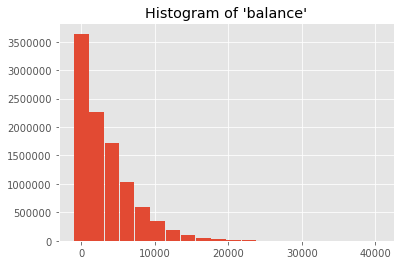

In [130]:
plt.bar(data['bins'], data['freq'], width=2000)
plt.title('Histogram of \'balance\'')
plt.savefig('B05793_05_22.png', dpi=300)

 - In a similar manner, a histogram can be create with Bokeh.

In [131]:
b_hist = chrt.Bar(data,
    values='freq', label='bins',
    title='Histogram of \'balance\'')
chrt.show(b_hist)

데이터의 수가 충분이 적다면, matplotlib의 hist 또는 Bokeh의 Histograme 함수를 사용해도 된다. 

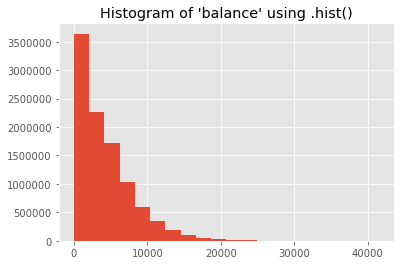

In [132]:
data_driver = {'obs': fraud_df.select('balance').rdd.flatMap(lambda row: row).collect()}
plt.hist(data_driver['obs'], bins=20)
plt.title('Histogram of \'balance\' using .hist()')

In [133]:
b_hist_driver = chrt.Histogram(data_driver, values='obs',title='Histogram of \'balance\' using .Histogram()',bins=20)
chrt.show(b_hist_driver)

### Interactions between features
 - 산포도(Scatter plot)의 경우 우리는 최대 3가지의 변수를 동시에 사용할 수 있다. 

In [134]:
data_sample = fraud_df.sampleBy('gender', {1: 0.0002, 2: 0.0002}).select(numerical)

 - put multiple 2D charts in one go

In [135]:
data_multi = dict([(elem, data_sample.select(elem).rdd.flatMap(lambda row: row).collect()) for elem in numerical])
sctr = chrt.Scatter(data_multi, x='balance', y='numTrans')
chrt.show(sctr)

## Summary

we looked at how to clean and prepare dataset for modeling by identifying and tackling datasets with missing values, duplicates, and outliers.